###Força bruta

In [2]:
def brute_force(T: str, n: int, P: str, m: int):
    
    ans = []
    for i in range(n-m+1):
        k=i
        j=0

        while (j < m) and (T[k] == P[j]):
            j+=1 
            k+=1

        if j == m:            
            #print(f"Casamento na posição {i}")
            ans.append(i)

    return ans


###BMH

In [20]:
def bmh(T: str, n: int, P: str, m: int):
    d = [m for i in range(256+1)]
    ans = []
    for j in range(1, m):
        d[ord(P[j-1])] = m-j

    i = m
    while i <= n:
        k=i
        j=m

        while (j > 0) and (T[k-1] == P[j-1]):
            j-=1
            k-=1

        if j == 0:
            #print(f"Casamento na posição {k}")
            ans.append(k)
        
        i+= d[ord(T[i-1])]
    
    return ans    


###BMHS

In [19]:
def bmhs(T: str, n: int, P: str, m: int):
    d = [m+1 for i in range(256+1)]
    ans = []

    for j in range(1, m+1):
        d[ord(P[j-1])] = m-j+1

    i = m
    while i <= n:
        k=i
        j=m

        while (j > 0) and (T[k-1] == P[j-1]):
            j-=1
            k-=1

        if j == 0:
            #print(f"Casamento na posição {k}")
            ans.append(k)
        
        
        i+= d[ord(T[i])] if i+m < n else 1;

    return ans


###Shift-And Exato

In [ ]:
def exact_shift_and(T: str, n: int, P: str, m: int):

    # m = len(P)
    # n = len(T)
    ans = []
    M = {}
    for c in "".join(dict.fromkeys(P)):
        M[c] = 0 << m
    
    for j in range(m):
        M[P[j]] = M[P[j]] | (1 << m-j-1) 

    R = 0
    for i in range(n):
        R = ((R>>1) | (1 << m-1)) & (M.get(T[i], 0))
        if (R & 1) != 0: 
            #print(f"Casamento na posição {i-m+1}")
            ans.append(i-m+1)


    return ans


###Shift-And Aproximado

In [ ]:
def approximated_shift_and(T: str, n: int, P: str, m: int, k=0):

    #m = len(P)
    #n = len(T)
    ans = []
    M = {}
    R = [0]

    for c in "".join(dict.fromkeys(P)):
        M[c] = 0
    
    for j in range(m):
        M[P[j]] = M[P[j]] | (1 << m-j-1) 

    #Pesquisa
    for j in range(1, k+1):
        
        #R.append(((1 << j-1) | R[j-1]) << m-j)
        R.append((1 << (5 - j)) | R[j-1])
            
    
    for i in range(n):
        R_ant = R[0]
        R_novo = ((R_ant >> 1) | (1 << m-1)) & M.get(T[i], 0)
        R[0] = R_novo;
        for j in range(1, k+1):
            R_novo = ((R[j] >> 1) & M.get(T[i], 0)) | R_ant | ((R_ant | R_novo) >> 1)
            R_ant = R[j]
            R[j] = R_novo | (1 << m-1)
        
        if (R_novo & 1) != 0:
            #print(f"Casamento na posição {i-m+1}");
            ans.append(i-m+1)

    return ans

###Plot dos gráficos

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from time import perf_counter
from matplotlib import rc

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [9]:
algorithms = [brute_force,
              bmh,
              bmhs,
              exact_shift_and,
              approximated_shift_and, #k=1
              approximated_shift_and] #k=2


raw_runtimes = [[] for i in range(5)]
average_runtimes = []

url = 'https://raw.githubusercontent.com/EudeMonteiro/Pattern-Matching/main/texts/'
text_lengths = [500, 1000, 1500, 2000, 5000]
pattern = "ipsum"


def getAverageTime(algorithm, parameters: tuple, asa_flag:bool = False, repeat: int = 10) -> float:
    
    timeConsumption = 0    
        
    for _ in range(repeat):
        T, n, P, m = parameters
        if asa_flag:            
            
            time_start = perf_counter()
            algorithm(T, n, P, m, k)
            time_end = perf_counter()
            timeConsumption += time_end - time_start            

        else:
            time_start = perf_counter()
            algorithm(T, n, P, m)
            time_end = perf_counter()
            timeConsumption += time_end - time_start
    asa_flag = False
    

    return timeConsumption/repeat 


def getAlgorithmsRuntime() -> list:

    algorithms_runtime = []
    asa_flag = False # Boolean flag for Approximated-Shift-And algorithm
    global k

    for algorithm in algorithms:
        
        if algorithm.__name__ == "approximated_shift_and":
            asa_flag = True
            k+=1

        runtimes = []
        for text_length in text_lengths:
                        
            # rstrip() removes newline character at the end of the file
            text_file = requests.get(url + f"T_{text_length}.txt").text.rstrip()
            parameters = (text_file, len(text_file), pattern, len(pattern))
            
            average_runtime = getAverageTime(algorithm, parameters, asa_flag)
            runtimes.append(average_runtime)

        algorithms_runtime.append(runtimes)

    return algorithms_runtime


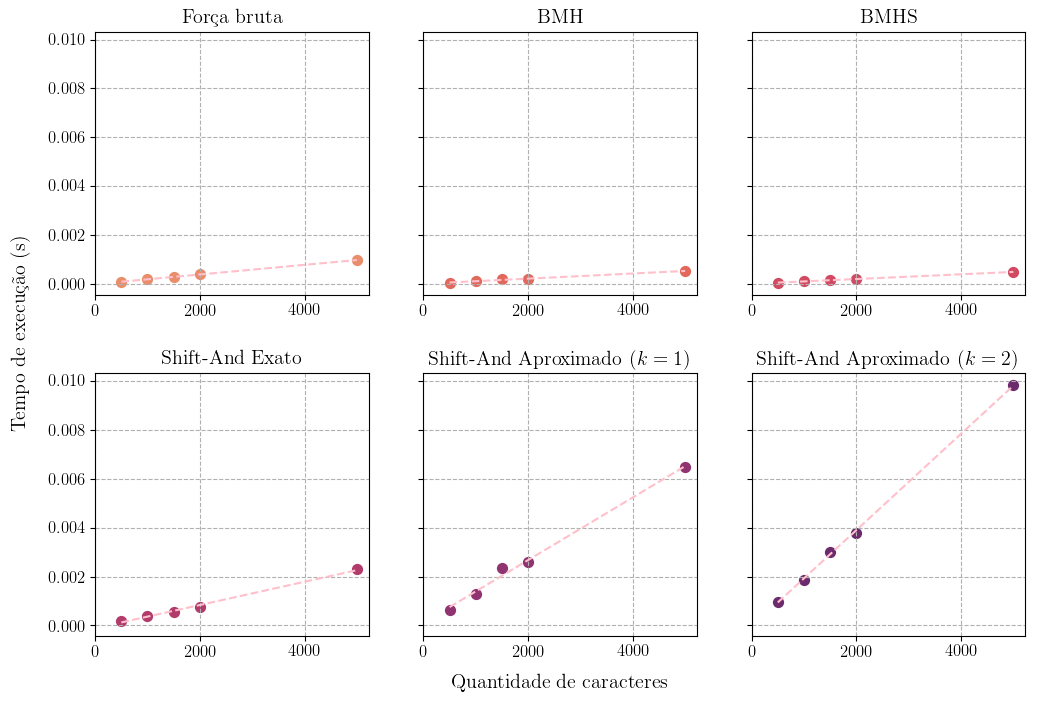

In [18]:
def plot_graph():
    
    fig, ax = plt.subplots(2,3, figsize=(12, 8), sharey=True, dpi=100)
    algorithms_runtime = getAlgorithmsRuntime()
    titles = ["Força bruta",
              "BMH",
              "BMHS",
              "Shift-And Exato",
              "Shift-And Aproximado ($k=1$)",
              "Shift-And Aproximado ($k=2$)"]

    colors = ['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']

    for i, ax_ in enumerate(ax.flatten()):

        b, a = np.polyfit(text_lengths, algorithms_runtime[i], 1)
                    
        ax_.plot(text_lengths, a + b * np.array(text_lengths), linestyle='--', color='pink')
        ax_.scatter(text_lengths, algorithms_runtime[i], s=50, color=colors[i])
        ax_.grid(linestyle='--')    
        ax_.set_title(titles[i])
        #ax_.set_xlabel("Quantidade de caracteres")
        #ax_.set_ylabel("Tempo de execução (s)")
        ax_.set_xlim(0, )

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Quantidade de caracteres", labelpad=10.0, fontsize="large")
    plt.ylabel("Tempo de execução (s)", labelpad=25.0,  fontsize="large")
    plt.rcParams.update({"text.usetex": True})
    plt.rcParams["font.family"] = "Times New Roman"

    fig.subplots_adjust(hspace=0.3)
    plt.show()

k = 0 # editing distance k for approximated shift-and algorithm
plot_graph()

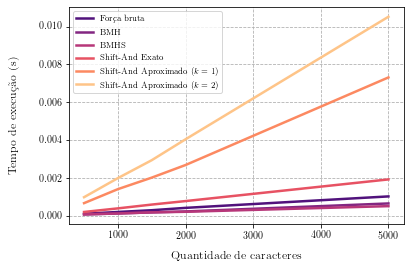

In [11]:
def plot_graph_2():
        
    algorithms_runtime = getAlgorithmsRuntime()
    titles = ["Força bruta",
              "BMH",
              "BMHS",
              "Shift-And Exato",
              "Shift-And Aproximado ($k=1$)",
              "Shift-And Aproximado ($k=2$)"]

    colors = ['#51127c', '#832681', '#b73779', '#e75263', '#fc8961', '#fec488']

    for i in range(len(algorithms_runtime)):
        plt.plot(text_lengths, algorithms_runtime[i], linewidth=2.5, color = colors[i])

    #plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.grid(linestyle='--')
    plt.xlabel("Quantidade de caracteres", labelpad=10.0, fontsize="large")
    plt.ylabel("Tempo de execução (s)", labelpad=20.0,  fontsize="large")
    plt.rcParams.update({"text.usetex": True})
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (5,5)
    plt.rcParams['figure.dpi'] = 110
    plt.legend(titles, fontsize='small')
    
    plt.show()

k = 0 # editing distance k for approximated shift-and algorithm
plot_graph_2()

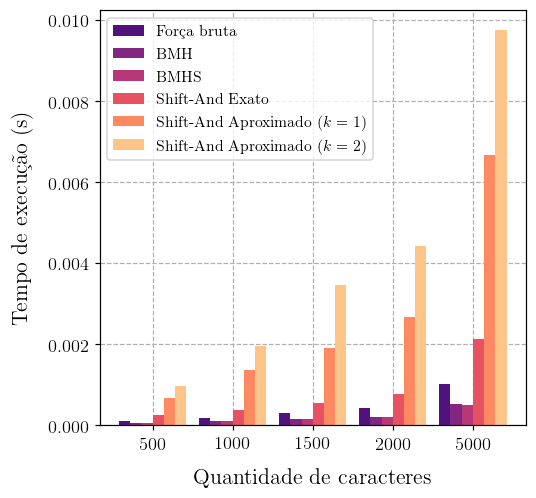

In [17]:
def plot_graph_3():
    
    algorithms_runtime = getAlgorithmsRuntime()
    titles = ["Força bruta",
              "BMH",
              "BMHS",
              "Shift-And Exato",
              "Shift-And Aproximado ($k=1$)",
              "Shift-And Aproximado ($k=2$)"]

    colors = ['#51127c', '#832681', '#b73779', '#e75263', '#fc8961', '#fec488']

    fig, ax = plt.subplots(figsize=(5,5))
    width = 0.5


    single_width=1
    total_width=.7

    n_bars = len(algorithms_runtime[0])   
    bar_width = total_width / n_bars

    bars = []

    for i, values in enumerate(algorithms_runtime):
        
        x_offset = (i - n_bars / 2) * bar_width

        
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        
        bars.append(bar[0])
    


    # ax.set_xticks(x+2.5)
    # ax.set_xticklabels( text_lengths )
    # plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_axisbelow(True)
    
    ax.set_xticks(list(range(5)))
    ax.set_xticklabels(text_lengths)
  
    ax.grid(linestyle='--', zorder=-1)
    plt.xlabel("Quantidade de caracteres", labelpad=10.0, fontsize="large")
    plt.ylabel("Tempo de execução (s)", labelpad=10.0,  fontsize="large")
    plt.rcParams.update({"text.usetex": True})
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 12})
    #plt.rcParams["figure.figsize"] = (10,10)
    plt.rcParams['figure.dpi'] = 110
    ax.legend(bars, titles, fontsize='small')
    plt.show()

k = 0
plot_graph_3()